<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tenure-Duration" data-toc-modified-id="Tenure-Duration-1">Tenure Duration</a></span></li><li><span><a href="#Race" data-toc-modified-id="Race-2">Race</a></span></li></ul></div>

Adapted from [this](https://github.com/waddell/urban-informatics-and-visualization/blob/master/Other%20Materials/19%20-%20Working-With-PUMS-Data.ipynb) notebook by Aksel Olsen

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [47]:
## function to be passed by groupby.apply to returned weighted estimate--no standard errors provided
def get_weighted_mean(frame, var, weight):
    """
    Takes ungrouped observations, splits into groups, applies the logic below, and combines groups into one table. 
    Needs the numeric variable (var) as well as the group by varible (group, as a list) to be passed. Basically
    a weighted mean by categorical group.
    """
    
    ## A: calculates the weighted value of the variable at the level of each observation
    weighted_x = frame[weight] * frame[var]  

    try:
        # sums value for the group and divides by weighted sum of records, returning
        # one value for each group. 
        estimate = weighted_x.sum() / frame[weight].sum()
    
    except ZeroDivisionError:
        estimate = 0

    return pd.DataFrame(data={var:[estimate]})

## function to be passed by groupby.apply to returned weighted estimate--no standard errors provided
def weighted_SE(frame, var, weights):

    ## A: calculates the weigted value of var x at the level of each observation
    wcol = [] # weight collection
    primary = [] # holder of the main estimate
    
    ## calculate 81 estimates (the last 80 being replicates)
    for w in weights:
        weighted_x = frame[w] * frame[var]  
        repl_estimate = weighted_x.sum() / frame[w].sum()
        wcol.append(repl_estimate)
    
    primary.append(wcol[0])
    wcol = wcol[1:]        
    squared_difference = 0

    primaryWeightSum = pd.Series(primary).sum()
    replicateWeightsSum = pd.Series(wcol).sum() 
    
    ## loop through each rep weight column, calculate sq difference with main weight     
    for col in wcol:
        squared_difference = squared_difference + (col - primary[0])**2

    # formula derived from: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2012AccuracyPUMS.pdf
    variance =(4 / 80.) * squared_difference
    standard_error = (variance)**.5
    
    return pd.DataFrame(data={var:[primaryWeightSum], 'se':standard_error})

In [2]:
pums_h = pd.read_csv("/Users/max/Downloads/csv_hca(2)/ss12hca.csv")

In [3]:
pums_h.index=pums_h.SERIALNO

In [4]:
pums_p = pd.read_csv("/Users/max/Downloads/csv_pca(1)/ss12pca.csv")

In [5]:
print("there are %s observations of %s variables in the housing table " %(pums_h.shape[0],pums_h.shape[1]))
print("there are %s observations of %s variables in the population table " %(pums_p.shape[0],pums_p.shape[1]))

there are 153115 observations of 206 variables in the housing table 
there are 368047 observations of 286 variables in the population table 


In [6]:
bayareafips ={'001':'Alameda', '013':'Contra Costa', '041':'Marin', '055':'Napa', '075':'San Francisco', '081':'San Mateo', '085':'Santa Clara', '095':'Sonoma', '097':'Solano'}
bayareafips.keys()

dict_keys(['001', '013', '041', '055', '075', '081', '085', '095', '097'])

In [7]:
sfPUMAS = [k for k in range(7501,7508)]
sfPUMAS

[7501, 7502, 7503, 7504, 7505, 7506, 7507]

In [8]:
pums_p = pums_p[pums_p.PUMA.isin(sfPUMAS)]
pums_p.shape

(7311, 286)

In [9]:
pums_h = pums_h[pums_h.PUMA.isin(sfPUMAS)]
pums_h.shape

(3586, 206)

In [11]:
sf_pop = pums_p.PWGTP.sum()
sf_pop

824855

# Get human-readable labels

In [14]:
# we skip the blank category here--Ideally fix, but currently most vars are loaded as integers, so 'bb' won't work here

# RACE
# note that these are not actually verbatim categories from the code book. Instead, this collapses categories.
codesrace = {
    1: "White",
    2: "Black",
    3: "Other",
    4: "Other",
    5: "Other",
    6: "Asian",
    7: "Other",
    8: "Other",
    9: "Two + Races"
}

# TENURE
codesten={
    1.0: "Owned with mortgage or loan (include home equity loans)",
    2.0: "Owned free and clear",
    3.0: "Rented",
    4.0: "Occupied without payment of rent"
}

## YEAR BUILT
codeybl={
    1.0: "1939 or earlier",
    2.0: "1940 to 1949",
    3.0: "1950 to 1959",
    4.0: "1960 to 1969",
    5.0: "1970 to 1979",
    6.0: "1980 to 1989",
    7.0: "1990 to 1999",
    8.0: "2000 to 2004",
    9.0: "2005",
    10.0: "2006",
    11.0: "2007",
    12.0: "2008",
    13.0: "2009",
    14.0: "2010",
    15.0: "2011",
    16.0: "2012"
}

# YEAR MOVED INTO UNIT
codemovein={
    1: "12 months or less",
    2: "13 to 23 months",
    3: "2 to 4 years",
    4: "5 to 9 years",
    5: "10 to 19 years",
    6: "20 to 29 years",
    7: "30 years or more",
}

# num units
codebldg={
    1.0: "Mobile home or trailer",
    2.0: "One-family house detached",
    3.0: "One-family house attached",
    4.0: "2 Apartments",
    5.0: "3-4 Apartments",
    6.0: "5-9 Apartments",
    7.0: "10-19 Apartments",
    8.0: "20-49 Apartments",
    9.0: "50 or more apartments",
    10.0: "Boat, RV, van, etc."
}

code_sex = {
    1: 'Male',
    2: 'Female'
}

code_hupac = {}

In [29]:
pums_p['RAC1P_l'] = pums_p['RAC1P'].map(codesrace)
pums_p['RAC1P_l'].value_counts(dropna=False)

White          3651
Asian          2481
Black           406
Other           405
Two + Races     368
Name: RAC1P_l, dtype: int64

In [30]:
pums_h['MV_l'] = pums_h['MV'].map(codemovein)
pums_h['MV_l'].value_counts(dropna=False)

5 to 9 years         673
2 to 4 years         592
10 to 19 years       577
13 to 23 months      420
30 years or more     406
12 months or less    402
20 to 29 years       365
NaN                  151
Name: MV_l, dtype: int64

In [31]:
pums_h['TEN_l'] = pums_h['TEN'].map(codesten)
pums_h['TEN_l'].value_counts(dropna=False)

Rented                                                     1784
Owned with mortgage or loan (include home equity loans)     935
NaN                                                         428
Owned free and clear                                        396
Occupied without payment of rent                             43
Name: TEN_l, dtype: int64

In [32]:
pums_h['YBL_l'] = pums_h['YBL'].map(codeybl)
pums_h['YBL_l'].value_counts(dropna=False)

1939 or earlier    1617
1950 to 1959        366
1940 to 1949        366
1960 to 1969        278
NaN                 277
1970 to 1979        214
1980 to 1989        152
1990 to 1999        113
2000 to 2004         89
2007                 27
2005                 24
2009                 22
2008                 12
2010                 12
2006                 10
2011                  6
2012                  1
Name: YBL_l, dtype: int64

In [33]:
pums_p['SEX_l'] = pums_p['SEX'].map(code_sex)

In [34]:
pums_p['DISAB_l'] = pums_p['DIS'].map({1: 'Yes', 2: 'No'})

In [35]:
pums_p['DISAB_l'].value_counts(dropna=False)

No     6485
Yes     826
Name: DISAB_l, dtype: int64

In [36]:
pums_h['SNAP_recipient'] = pums_h['FS'].map({1: 'Yes', 2: 'No'})

In [168]:
pums_p['pub_asst_inc'] = 'No'
pums_p.loc[pums_p['PAP'] > 0, 'pub_asst_inc'] = 'Yes'

In [171]:
pums_p['HISP_l'] = 'No'
pums_p.loc[pums_p['HISP'] > 1, 'HISP_l'] = 'Yes' 

# Just get the renters

In [38]:
pums_h_rent = pums_h[pums_h['TEN_l'] == 'Rented'].copy()

In [39]:
pums_h_rent.WGTP.sum()

216427

# Rent control proxy

In [42]:
pums_h_rent['rent_control'] = (pums_h_rent['YBL'] <= 5) & (pums_h_rent['BLD'].between(4, 9))

In [43]:
pums_h_rent['rent_control'].value_counts()

True     1316
False     468
Name: rent_control, dtype: int64

In [197]:
pums_p_rent = pums_p.merge(pums_h_rent[['rent_control', 'YBL', 'BLD']].reset_index(), on='SERIALNO', how='left') 

In [198]:
pums_p_rent['rent_control'].value_counts()

True     2375
False    1137
Name: rent_control, dtype: int64

# Masks

In [272]:
p_mask = pums_p_rent['YBL'].between(3, 11)
h_mask = pums_h_rent['YBL'].between(3, 11)

# Plots

### Tenure Duration

In [85]:
grp_col = 'rent_control'
wgt_col = 'WGTP'
value_col = 'MV_l'
new_col = 'pct_pop'
marginals = pums_h_rent.groupby(grp_col)[[wgt_col]].sum().rename(columns={'WGTP': 'total'}).reset_index()

Text(0, 0.5, '% Pop. by Rent Control Status')

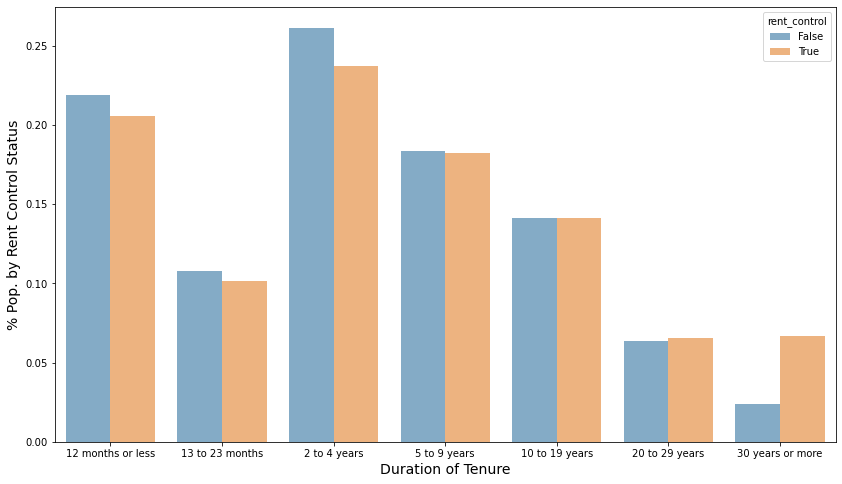

In [98]:
fig, ax = plt.subplots(figsize=(14, 8))

joint_df = pums_h_rent[[grp_col, value_col, wgt_col]].groupby([grp_col, value_col]).sum()
joint_df = joint_df.reset_index()
joint_df = pd.merge(joint_df, marginals, on=grp_col)
joint_df[new_col] = joint_df[wgt_col] / joint_df['total']

sns.barplot(
    x=value_col, y=new_col,
    data=joint_df, hue=grp_col, alpha=0.6,
    order=['12 months or less', '13 to 23 months', '2 to 4 years', '5 to 9 years', '10 to 19 years', '20 to 29 years', '30 years or more']
)

ax.set_xlabel("Duration of Tenure", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [166]:
def get_weighted_pct_pop(pums_df, grp_col, wgt_col, value_col, new_col):

    marginals = pums_df[[grp_col, value_col, wgt_col]].groupby(grp_col)[[wgt_col]].sum().rename(
        columns={wgt_col: 'total'}).reset_index()
    joint_df = pums_df[[grp_col, value_col, wgt_col]].groupby([grp_col, value_col]).sum()
    joint_df = joint_df.reset_index()
    joint_df = pd.merge(joint_df, marginals, on=grp_col)
    joint_df[new_col] = joint_df[wgt_col] / joint_df['total']
    
    return joint_df

def get_weighted_agg_se(weighted_agg_func, pums_df, grp_col, wgt_col, value_col, new_col='pct_pop'):
    
    repl_cols = [wgt_col] + [col for col in pums_df.columns if wgt_col.lower() in col]
    
    repls = [] # weight collection

    for repl_col in repl_cols:
        repl_estimate = weighted_agg_func(pums_df, grp_col, repl_col, value_col, new_col)
        repls.append(repl_estimate)

    primary = repls[0]
    primary['tot_err'] = 0
    repls = repls[1:]        

    ## loop through each rep weight column, calculate sq difference with main weight     
    for repl in repls:
        primary['tot_err'] = primary['tot_err'] + (repl[new_col] - primary[new_col]) ** 2

    # formula derived from: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2012AccuracyPUMS.pdf
    variance = (4 / 80.) * primary['tot_err']
    primary['se'] = (variance) ** .5
    
    return primary

# Children

In [328]:
pums_h_rent['HUPAC_l'] = pums_h_rent['HUPAC'].map({
    4: 'no children', 1: 'only children under 6', 2: 'only children 6 to 17', 3: 'children under 6 and over 6'})

Text(0, 0.5, '% Pop. by Rent Control Status')

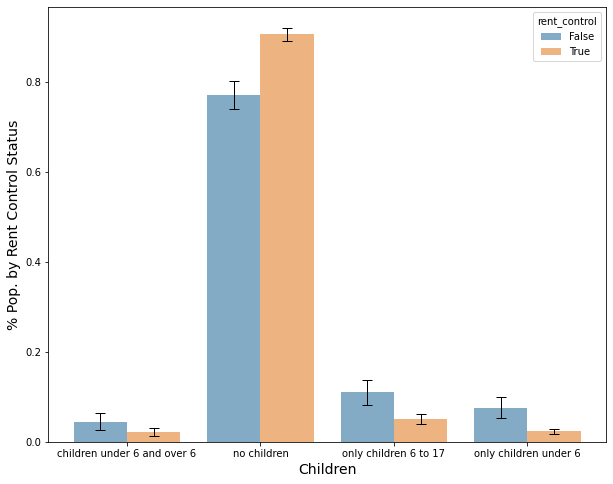

In [330]:
fig, ax = plt.subplots(figsize=(10, 8))

pums_df = pums_h_rent
grp_col = 'rent_control'
wgt_col = 'WGTP'
value_col = 'HUPAC_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Children", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [332]:
weighted_agg_df.pivot(index='HUPAC_l', columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control                    False     True      False     True 
HUPAC_l                                                            
children under 6 and over 6  0.044958  0.021759  0.010990  0.004966
no children                  0.769338  0.904669  0.018995  0.009203
only children 6 to 17        0.109543  0.050678  0.016843  0.006602
only children under 6        0.076161  0.022894  0.014422  0.003709

Text(0, 0.5, '% Pop. by Rent Control Status')

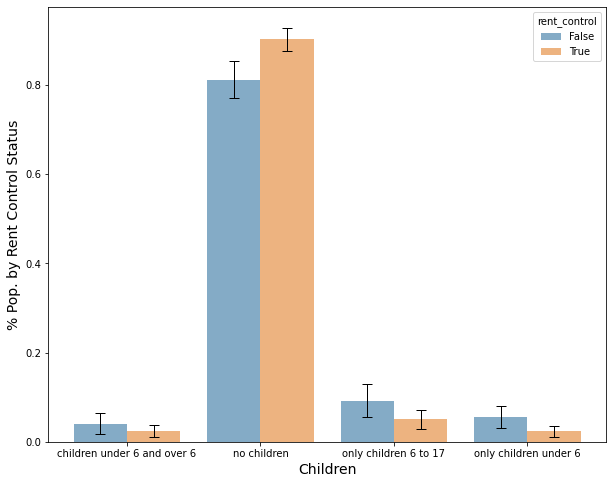

In [333]:
fig, ax = plt.subplots(figsize=(10, 8))

pums_df = pums_h_rent[h_mask]
grp_col = 'rent_control'
wgt_col = 'WGTP'
value_col = 'HUPAC_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Children", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [334]:
weighted_agg_df.pivot(index='HUPAC_l', columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control                    False     True      False     True 
HUPAC_l                                                            
children under 6 and over 6  0.040649  0.024186  0.014041  0.008344
no children                  0.811185  0.901612  0.025269  0.015966
only children 6 to 17        0.092293  0.050193  0.022611  0.012745
only children under 6        0.055873  0.024010  0.014592  0.007601

### Race

Text(0, 0.5, '% Pop. by Rent Control Status')

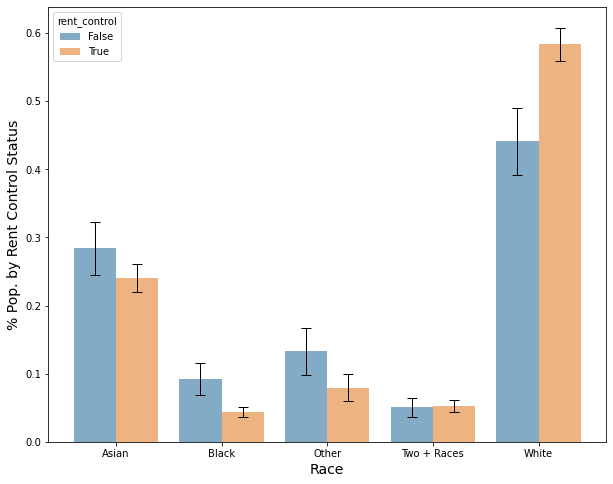

In [200]:
fig, ax = plt.subplots(figsize=(10, 8))

pums_df = pums_p_rent
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'RAC1P_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Race", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [202]:
weighted_agg_df.pivot(index='RAC1P_l', columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
RAC1P_l                                             
Asian         0.283867  0.240324  0.023350  0.012532
Black         0.092015  0.044126  0.014332  0.004590
Other         0.132780  0.079517  0.020866  0.012096
Two + Races   0.050470  0.052476  0.008727  0.005186
White         0.440868  0.583557  0.029623  0.014769

Text(0.5, 1.0, 'Renters in Multi-Unit Buildings Built 1950-2007')

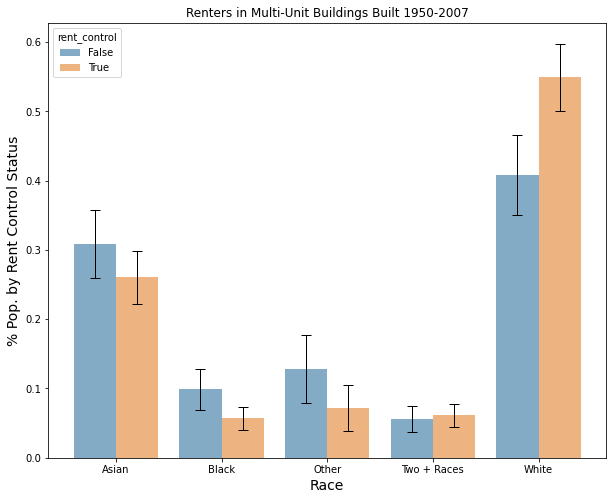

In [273]:
fig, ax = plt.subplots(figsize=(10, 8))

pums_df = pums_p_rent[p_mask]
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'RAC1P_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Race", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)
ax.set_title("Renters in Multi-Unit Buildings Built 1950-2007")

In [274]:
weighted_agg_df.pivot(index=value_col, columns=grp_col, values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
RAC1P_l                                             
Asian         0.308800  0.260691  0.029653  0.023352
Black         0.098705  0.056789  0.018237  0.009877
Other         0.127903  0.071988  0.030022  0.020087
Two + Races   0.056400  0.061205  0.011559  0.009868
White         0.408193  0.549326  0.035316  0.029353

Text(0, 0.5, '% Pop. by Rent Control Status')

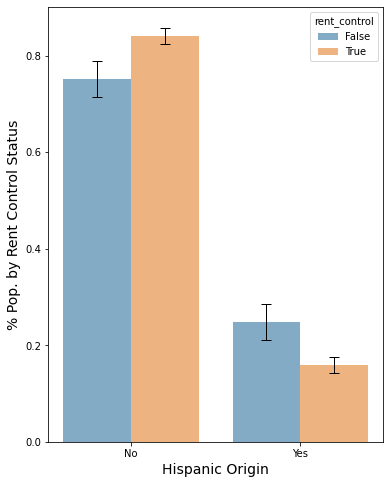

In [203]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'HISP_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Hispanic Origin", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [206]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
HISP_l                                              
No            0.751929  0.841108  0.022253  0.010328
Yes           0.248071  0.158892  0.022253  0.010328

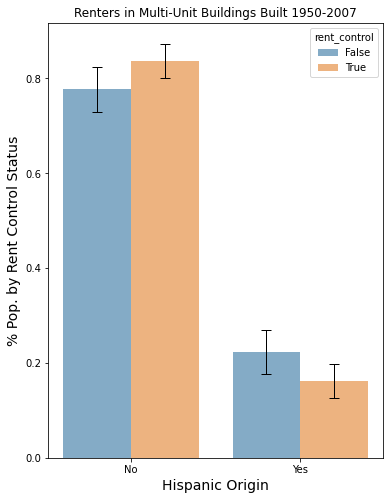

In [275]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent[p_mask]
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'HISP_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Hispanic Origin", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)
_ = ax.set_title("Renters in Multi-Unit Buildings Built 1950-2007")

In [276]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                se         
rent_control     False   True      False    True 
HISP_l                                           
No            0.776941  0.8373  0.028798  0.02186
Yes           0.223059  0.1627  0.028798  0.02186

# Sex

Text(0, 0.5, '% Pop. by Rent Control Status')

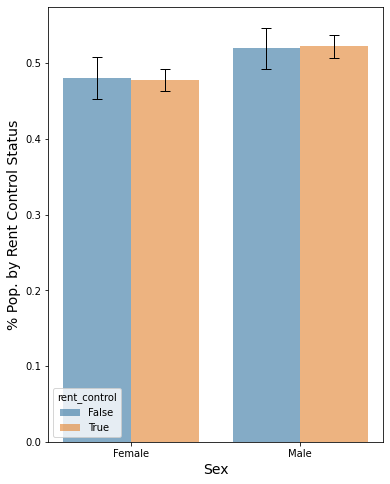

In [207]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'SEX_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Sex", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [208]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                 se          
rent_control    False    True      False     True 
SEX_l                                             
Female        0.48041  0.47773  0.016587  0.009102
Male          0.51959  0.52227  0.016587  0.009102

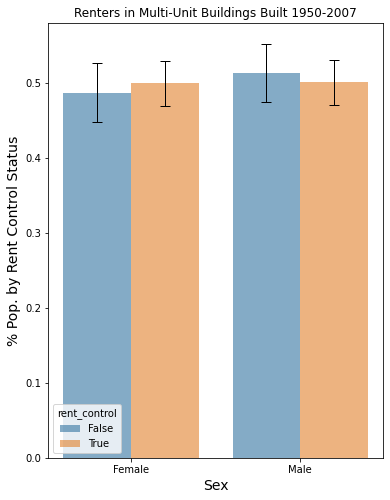

In [277]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent[p_mask]
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'SEX_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Sex", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)
_ = ax.set_title("Renters in Multi-Unit Buildings Built 1950-2007")

In [278]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
SEX_l                                               
Female        0.486926  0.499166  0.023707  0.018284
Male          0.513074  0.500834  0.023707  0.018284

# Race $\times$ Sex

Text(0, 0.5, '% Pop. by Rent Control Status')

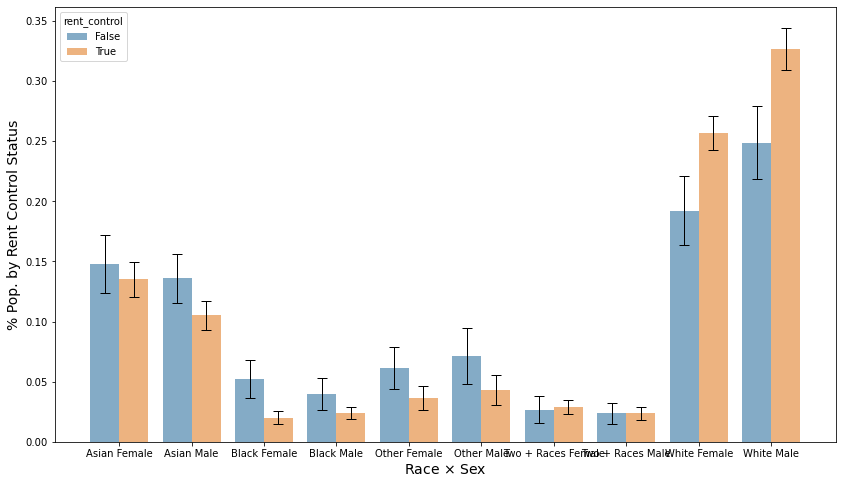

In [209]:
fig, ax = plt.subplots(figsize=(14, 8))

pums_df = pums_p_rent.copy()
pums_df['race_sex'] = pums_df['RAC1P_l'] + ' ' + pums_df['SEX_l']
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'race_sex'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel(r"Race $\times$ Sex", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [210]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control           False     True      False     True 
race_sex                                                  
Asian Female        0.147989  0.135325  0.014578  0.008838
Asian Male          0.135878  0.104999  0.012266  0.007087
Black Female        0.052254  0.019992  0.009510  0.003174
Black Male          0.039761  0.024134  0.007862  0.003024
Other Female        0.061279  0.036524  0.010537  0.005958
Other Male          0.071500  0.042994  0.014190  0.007597
Two + Races Female  0.026818  0.028889  0.006725  0.003684
Two + Races Male    0.023653  0.023588  0.005326  0.003241
White Female        0.192070  0.257001  0.017330  0.008659
White Male          0.248798  0.326556  0.018333  0.010798

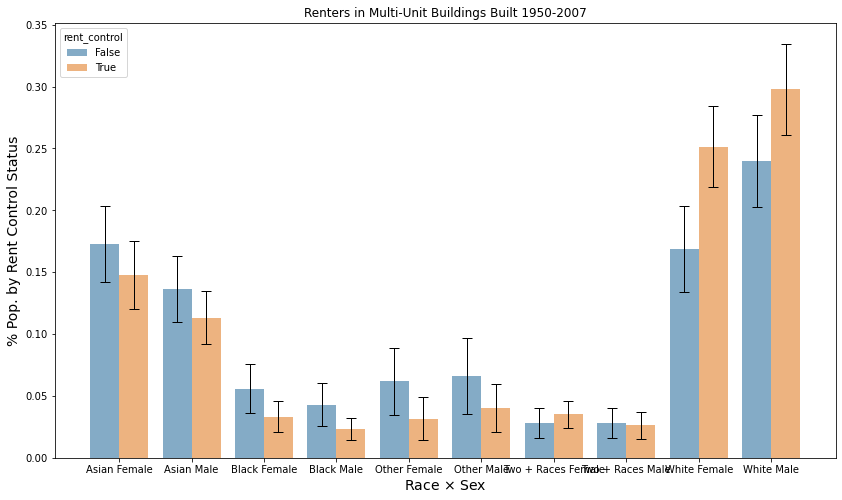

In [279]:
fig, ax = plt.subplots(figsize=(14, 8))

pums_df = pums_p_rent.copy()[p_mask]
pums_df['race_sex'] = pums_df['RAC1P_l'] + ' ' + pums_df['SEX_l']
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'race_sex'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel(r"Race $\times$ Sex", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)
_ = ax.set_title("Renters in Multi-Unit Buildings Built 1950-2007")

In [280]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control           False     True      False     True 
race_sex                                                  
Asian Female        0.172381  0.147459  0.018665  0.016722
Asian Male          0.136419  0.113232  0.016345  0.013101
Black Female        0.055912  0.033367  0.011856  0.007712
Black Male          0.042793  0.023423  0.010607  0.005347
Other Female        0.061955  0.031741  0.016440  0.010356
Other Male          0.065947  0.040248  0.018779  0.011830
Two + Races Female  0.027978  0.035066  0.007234  0.006733
Two + Races Male    0.028422  0.026139  0.007313  0.006468
White Female        0.168700  0.251534  0.020929  0.020063
White Male          0.239493  0.297792  0.022597  0.022431

Text(0, 0.5, '% Pop. by Rent Control Status')

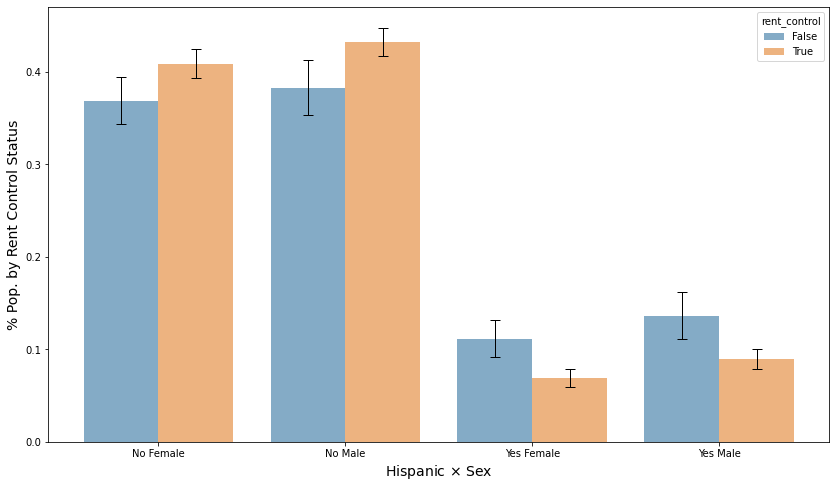

In [211]:
fig, ax = plt.subplots(figsize=(14, 8))

pums_df = pums_p_rent.copy()
pums_df['hisp_sex'] = pums_df['HISP_l'] + ' ' + pums_df['SEX_l']
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'hisp_sex'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel(r"Hispanic $\times$ Sex", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

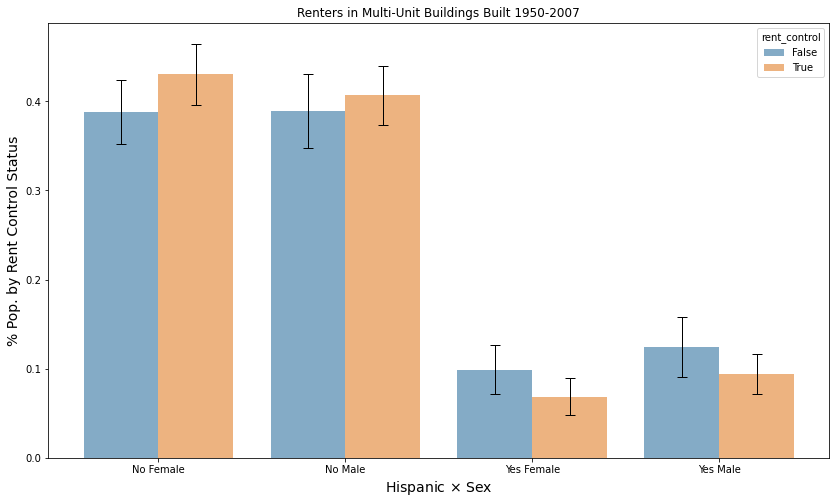

In [281]:
fig, ax = plt.subplots(figsize=(14, 8))

pums_df = pums_p_rent.copy()[p_mask]
pums_df['hisp_sex'] = pums_df['HISP_l'] + ' ' + pums_df['SEX_l']
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'hisp_sex'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel(r"Hispanic $\times$ Sex", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)
_ = ax.set_title("Renters in Multi-Unit Buildings Built 1950-2007")

In [282]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
hisp_sex                                            
No Female     0.387866  0.430534  0.021682  0.020802
No Male       0.389075  0.406766  0.025126  0.020168
Yes Female    0.099060  0.068632  0.016434  0.012455
Yes Male      0.123999  0.094068  0.020507  0.013507

# Disability Status

Text(0, 0.5, '% Pop. by Rent Control Status')

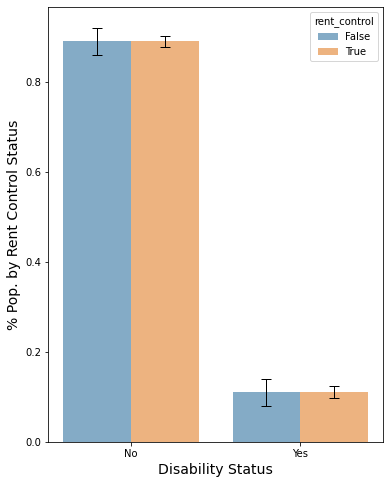

In [265]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'DISAB_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Disability Status", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [267]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
DISAB_l                                             
No            0.889757  0.889137  0.018265  0.007975
Yes           0.110243  0.110863  0.018265  0.007975

Text(0, 0.5, '% Pop. by Rent Control Status')

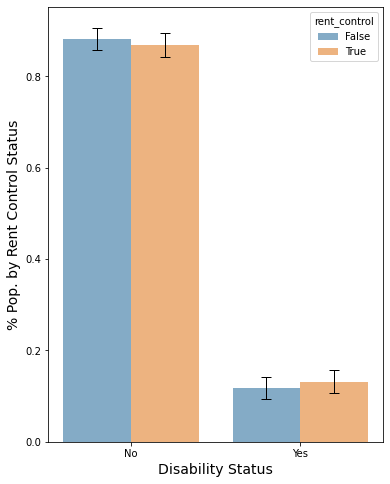

In [283]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent[p_mask]
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'DISAB_l'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Disability Status", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [284]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control   False     True      False     True 
DISAB_l                                           
No             0.882  0.868086  0.014883  0.015781
Yes            0.118  0.131914  0.014883  0.015781

# SNAP Assistance

Text(0, 0.5, '% Pop. by Rent Control Status')

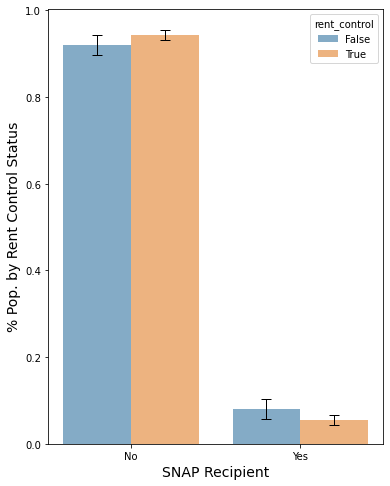

In [268]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_h_rent
grp_col = 'rent_control'
wgt_col = 'WGTP'
value_col = 'SNAP_recipient'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("SNAP Recipient", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [269]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control      False     True      False     True 
SNAP_recipient                                       
No              0.91943  0.944205  0.014109  0.007072
Yes             0.08057  0.055795  0.014109  0.007072

Text(0, 0.5, '% Pop. by Rent Control Status')

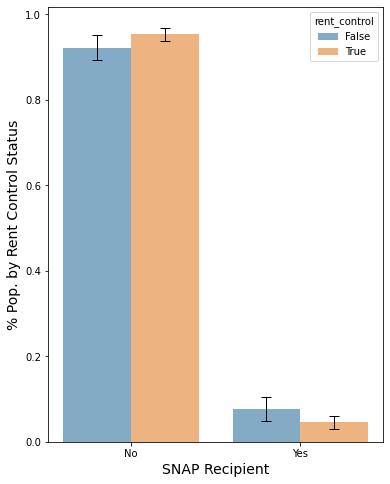

In [285]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_h_rent[h_mask]
grp_col = 'rent_control'
wgt_col = 'WGTP'
value_col = 'SNAP_recipient'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("SNAP Recipient", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [286]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control       False     True      False     True 
SNAP_recipient                                        
No              0.922508  0.953939  0.017268  0.009306
Yes             0.077492  0.046061  0.017268  0.009306

# Public Assistance Income

Text(0, 0.5, '% Pop. by Rent Control Status')

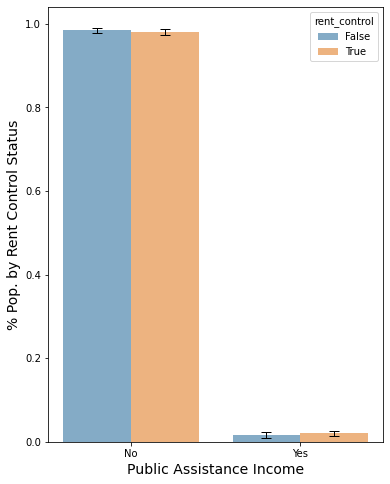

In [270]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'pub_asst_inc'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Public Assistance Income", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [271]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
pub_asst_inc                                        
No            0.984064  0.980025  0.003969  0.003907
Yes           0.015936  0.019975  0.003969  0.003907

Text(0, 0.5, '% Pop. by Rent Control Status')

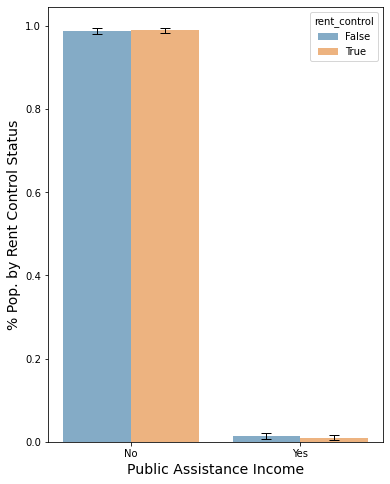

In [287]:
fig, ax = plt.subplots(figsize=(6, 8))

pums_df = pums_p_rent[p_mask]
grp_col = 'rent_control'
wgt_col = 'PWGTP'
value_col = 'pub_asst_inc'
new_col = 'pct_pop'

weighted_agg_df = get_weighted_agg_se(get_weighted_pct_pop, pums_df, grp_col, wgt_col, value_col, new_col)

sns.barplot(
    x=value_col, y=new_col,
    data=weighted_agg_df, hue=grp_col, alpha=0.6,
)

ax.errorbar(
    [patch.get_x() + (patch.get_width() / 2) for patch in ax.patches],
    weighted_agg_df[new_col], yerr=weighted_agg_df['se'] * 1.645,
    fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.')

ax.set_xlabel("Public Assistance Income", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [288]:
weighted_agg_df.pivot(index=value_col, columns='rent_control', values=['pct_pop', 'se'])

pct_pop                  se          
rent_control     False     True      False     True 
pub_asst_inc                                        
No            0.986859  0.989909  0.004514  0.003598
Yes           0.013141  0.010091  0.004514  0.003598

# Continuous vars

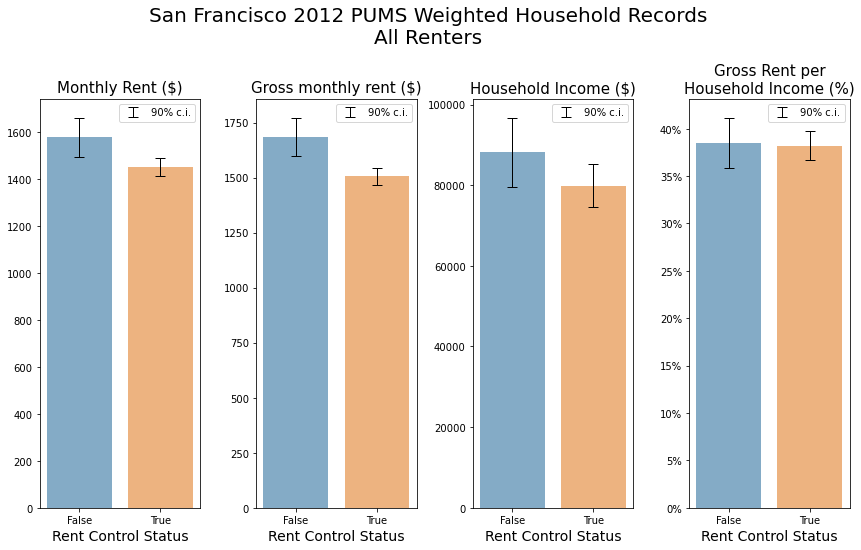

In [262]:
fig, axarr = plt.subplots(1, 4, figsize=(12, 8))
pums_df = pums_h_rent
wgt_col='WGTP'
grp_col='rent_control'
value_to_label = {
    'HINCP': 'Household Income ($)', 'GRPIP': 'Gross Rent per\nHousehold Income (%)', 'RNTP': 'Monthly Rent ($)',
    'GRNTP': 'Gross monthly rent ($)'
}

means_df = pd.DataFrame()
ses_df = pd.DataFrame()

for i, value_col in enumerate(['RNTP', 'GRNTP', 'HINCP', 'GRPIP']):

    ax = axarr[i]
    wgt_mean = pums_df[[wgt_col, value_col, grp_col]].groupby(grp_col).apply(weighted_mean, value_col, wgt_col).reset_index()
    means_df = pd.concat((means_df, wgt_mean[[grp_col, value_col]].set_index(grp_col).T))
    sns.barplot(data=wgt_mean, x='rent_control', y=value_col, ax=ax, alpha=0.6)
    if value_col == 'GRPIP':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control Status", fontsize=14)
    ax.set_ylabel("")
    ax.set_title(value_to_label[value_col], fontsize=15)

    wgt_se = [wgt_col] + pums_df.filter(like='wgtp', axis=1).columns.tolist()
    se = pums_df[wgt_se + [value_col, grp_col]].groupby(grp_col).apply(weighted_SE, value_col, wgt_se)['se']
    se.name = value_col
    ses_df = pd.concat((ses_df, se.reset_index()[[grp_col, value_col]].set_index(grp_col).T))
    yerr = se.values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value_col], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nAll Renters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])

In [264]:
means_df

rent_control,False,True
RNTP,1577.547664,1451.893305
GRNTP,1684.334792,1506.656615
HINCP,88114.149939,79871.598061
GRPIP,38.480049,38.201842


In [263]:
ses_df

rent_control,False,True
RNTP,50.044535,22.643428
GRNTP,52.145136,23.227395
HINCP,5174.001902,3209.269103
GRPIP,1.603667,0.926255


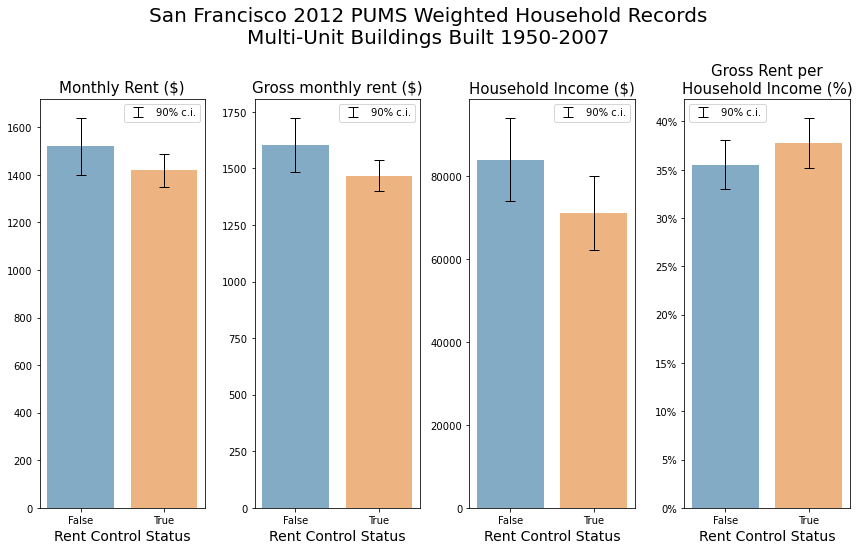

In [289]:
fig, axarr = plt.subplots(1, 4, figsize=(12, 8))
pums_df = pums_h_rent[h_mask]
wgt_col='WGTP'
grp_col='rent_control'
value_to_label = {
    'HINCP': 'Household Income ($)', 'GRPIP': 'Gross Rent per\nHousehold Income (%)', 'RNTP': 'Monthly Rent ($)',
    'GRNTP': 'Gross monthly rent ($)'
}

means_df = pd.DataFrame()
ses_df = pd.DataFrame()

for i, value_col in enumerate(['RNTP', 'GRNTP', 'HINCP', 'GRPIP']):

    ax = axarr[i]
    wgt_mean = pums_df[[wgt_col, value_col, grp_col]].groupby(grp_col).apply(weighted_mean, value_col, wgt_col).reset_index()
    means_df = pd.concat((means_df, wgt_mean[[grp_col, value_col]].set_index(grp_col).T))
    sns.barplot(data=wgt_mean, x='rent_control', y=value_col, ax=ax, alpha=0.6)
    if value_col == 'GRPIP':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control Status", fontsize=14)
    ax.set_ylabel("")
    ax.set_title(value_to_label[value_col], fontsize=15)

    wgt_se = [wgt_col] + pums_df.filter(like='wgtp', axis=1).columns.tolist()
    se = pums_df[wgt_se + [value_col, grp_col]].groupby(grp_col).apply(weighted_SE, value_col, wgt_se)['se']
    se.name = value_col
    ses_df = pd.concat((ses_df, se.reset_index()[[grp_col, value_col]].set_index(grp_col).T))
    yerr = se.values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value_col], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nMulti-Unit Buildings Built 1950-2007", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])

In [290]:
means_df

rent_control,False,True
RNTP,1519.410614,1418.408711
GRNTP,1602.523760,1468.718113
HINCP,83952.778729,71167.144429
GRPIP,35.531822,37.754754


In [291]:
ses_df

rent_control,False,True
RNTP,72.458319,42.015831
GRNTP,72.840677,42.612865
HINCP,6110.557449,5466.430219
GRPIP,1.518238,1.574333


# Age of Head

In [311]:
heads = pums_p_rent[pums_p_rent['RELP'] == 0].copy()
pums_h_rent = pums_h_rent.merge(heads[['AGEP', 'SERIALNO']], left_index=True, right_on='SERIALNO').set_index('SERIALNO')

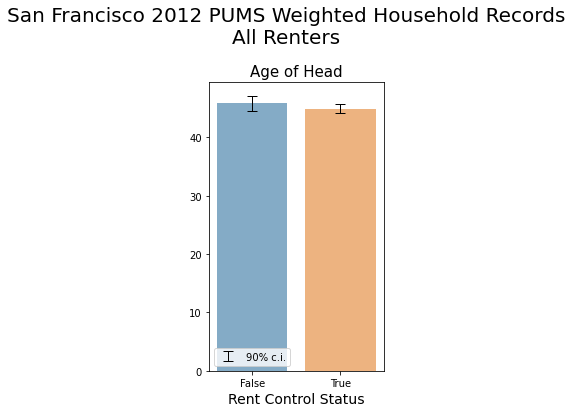

In [312]:
fig, ax = plt.subplots(figsize=(3, 6))
pums_df = pums_h_rent
wgt_col='WGTP'
grp_col='rent_control'
value_col = 'AGEP'
title = 'Age of Head'

wgt_mean = pums_df[[wgt_col, value_col, grp_col]].groupby(grp_col).apply(weighted_mean, value_col, wgt_col).reset_index()
means_df = pd.concat((means_df, wgt_mean[[grp_col, value_col]].set_index(grp_col).T))
sns.barplot(data=wgt_mean, x='rent_control', y=value_col, ax=ax, alpha=0.6)
ax.set_xlabel("Rent Control Status", fontsize=14)
ax.set_ylabel("")
ax.set_title(title, fontsize=15)

wgt_se = [wgt_col] + pums_df.filter(like='wgtp', axis=1).columns.tolist()
se = pums_df[wgt_se + [value_col, grp_col]].groupby(grp_col).apply(weighted_SE, value_col, wgt_se)['se']
se.name = value_col
ses_df = pd.concat((ses_df, se.reset_index()[[grp_col, value_col]].set_index(grp_col).T))
yerr = se.values
ci_90 = yerr * 1.645
ax.errorbar(
    x=[0, 1],y=wgt_mean[value_col], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.'
)
ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nAll Renters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])

In [313]:
wgt_mean.T

,0,1
rent_control,False,True
level_1,0,0
AGEP,45.7792,44.8858


In [314]:
se.reset_index().T

,0,1
rent_control,False,True
level_1,0,0
AGEP,0.753553,0.481946


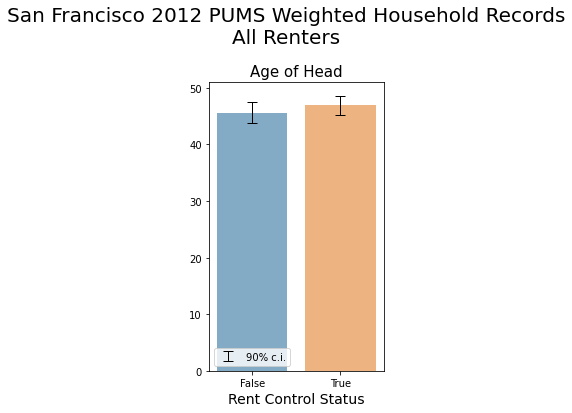

In [320]:
fig, ax = plt.subplots(figsize=(3, 6))
pums_df = pums_h_rent[h_mask]
wgt_col='WGTP'
grp_col='rent_control'
value_col = 'AGEP'
title = 'Age of Head'

wgt_mean = pums_df[[wgt_col, value_col, grp_col]].groupby(grp_col).apply(weighted_mean, value_col, wgt_col).reset_index()
means_df = pd.concat((means_df, wgt_mean[[grp_col, value_col]].set_index(grp_col).T))
sns.barplot(data=wgt_mean, x='rent_control', y=value_col, ax=ax, alpha=0.6)
ax.set_xlabel("Rent Control Status", fontsize=14)
ax.set_ylabel("")
ax.set_title(title, fontsize=15)

wgt_se = [wgt_col] + pums_df.filter(like='wgtp', axis=1).columns.tolist()
se = pums_df[wgt_se + [value_col, grp_col]].groupby(grp_col).apply(weighted_SE, value_col, wgt_se)['se']
se.name = value_col
ses_df = pd.concat((ses_df, se.reset_index()[[grp_col, value_col]].set_index(grp_col).T))
yerr = se.values
ci_90 = yerr * 1.645
ax.errorbar(
    x=[0, 1],y=wgt_mean[value_col], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.'
)
ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nAll Renters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])

In [321]:
wgt_mean.T

,0,1
rent_control,False,True
level_1,0,0
AGEP,45.5788,46.8731


In [322]:
se.reset_index().T

,0,1
rent_control,False,True
level_1,0,0
AGEP,1.1285,0.982604


# Number of children

In [342]:
pums_h_rent['NOC'].value_counts(dropna=False)

0.0    1549
1.0     124
2.0      90
3.0      12
4.0       9
Name: NOC, dtype: int64

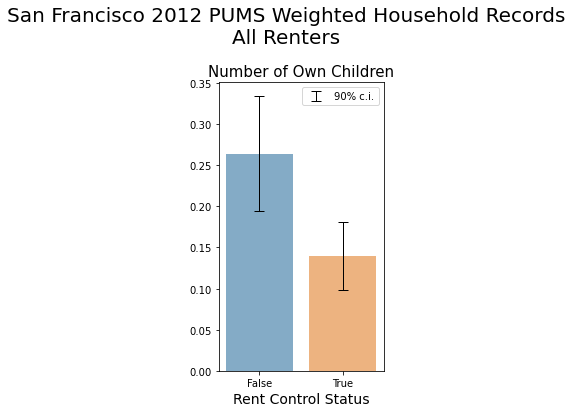

In [335]:
fig, ax = plt.subplots(figsize=(3, 6))
pums_df = pums_h_rent[h_mask]
wgt_col='WGTP'
grp_col='rent_control'
value_col = 'NOC'
title = 'Number of Own Children'

wgt_mean = pums_df[[wgt_col, value_col, grp_col]].groupby(grp_col).apply(weighted_mean, value_col, wgt_col).reset_index()
means_df = pd.concat((means_df, wgt_mean[[grp_col, value_col]].set_index(grp_col).T))
sns.barplot(data=wgt_mean, x='rent_control', y=value_col, ax=ax, alpha=0.6)
ax.set_xlabel("Rent Control Status", fontsize=14)
ax.set_ylabel("")
ax.set_title(title, fontsize=15)

wgt_se = [wgt_col] + pums_df.filter(like='wgtp', axis=1).columns.tolist()
se = pums_df[wgt_se + [value_col, grp_col]].groupby(grp_col).apply(weighted_SE, value_col, wgt_se)['se']
se.name = value_col
ses_df = pd.concat((ses_df, se.reset_index()[[grp_col, value_col]].set_index(grp_col).T))
yerr = se.values
ci_90 = yerr * 1.645
ax.errorbar(
    x=[0, 1],y=wgt_mean[value_col], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.'
)
ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nAll Renters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])

In [336]:
wgt_mean.T

,0,1
rent_control,False,True
level_1,0,0
NOC,0.263823,0.139142


In [339]:

se.reset_index().T

,0,1
rent_control,False,True
level_1,0,0
NOC,0.0424508,0.0250008


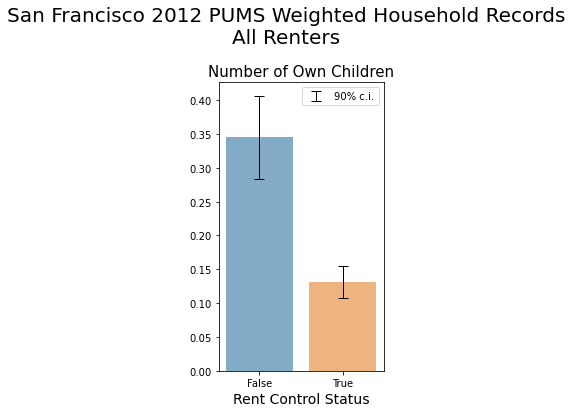

In [340]:
fig, ax = plt.subplots(figsize=(3, 6))
pums_df = pums_h_rent
wgt_col='WGTP'
grp_col='rent_control'
value_col = 'NOC'
title = 'Number of Own Children'

wgt_mean = pums_df[[wgt_col, value_col, grp_col]].groupby(grp_col).apply(weighted_mean, value_col, wgt_col).reset_index()
means_df = pd.concat((means_df, wgt_mean[[grp_col, value_col]].set_index(grp_col).T))
sns.barplot(data=wgt_mean, x='rent_control', y=value_col, ax=ax, alpha=0.6)
ax.set_xlabel("Rent Control Status", fontsize=14)
ax.set_ylabel("")
ax.set_title(title, fontsize=15)

wgt_se = [wgt_col] + pums_df.filter(like='wgtp', axis=1).columns.tolist()
se = pums_df[wgt_se + [value_col, grp_col]].groupby(grp_col).apply(weighted_SE, value_col, wgt_se)['se']
se.name = value_col
ses_df = pd.concat((ses_df, se.reset_index()[[grp_col, value_col]].set_index(grp_col).T))
yerr = se.values
ci_90 = yerr * 1.645
ax.errorbar(
    x=[0, 1],y=wgt_mean[value_col], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
    label='90% c.i.'
)
ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nAll Renters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.99])

In [343]:
wgt_mean.T

,0,1
rent_control,False,True
level_1,0,0
NOC,0.344546,0.130978


In [344]:
se.reset_index().T

,0,1
rent_control,False,True
level_1,0,0
NOC,0.0370429,0.014471
